# General Analysis Notebook
This notebook intents to tackle the problem of analyzing a whole batch. It mainly iterates over the many directories and process each one. Then makes a graph indicating the resulting value and the expected one. This is a neat way to understand how well is the analyzer performing generally.

## Requirements
This notebook requires that the root directory where reports are contains a ```description.yml``` file, indicating the various properties of the batch. Including the connection's top speed, the throttling configuration, the start time for each change and the time lapse for each throttling speed.

In [8]:
BATCHES_DIR = '/home/gaston/workspace/taller-3/tix/reports-batches/output/batch-test-report-10'
TEST_CONFIG_FILE = '/home/gaston/workspace/taller-3/tix/reports-batches/description.yml'

In [9]:
# Setup and import everything
%matplotlib notebook

import datetime
import math
import os
import pandas as pd
import yaml

from processor import analysis, reports

from IPython.display import display

# TODO pasar directorio de reportes por linea de comando o archivo de configuracion
base_directory = BATCHES_DIR
with open(TEST_CONFIG_FILE) as fp:
    batch_description = yaml.load(fp)
batch_description

{'connection_speed': 1500,
 'experiment': [{'lapse': 3600, 'speed': 1500, 'start': 1513310400},
  {'lapse': 3600, 'speed': 1125, 'start': 1513314000},
  {'lapse': 3600, 'speed': 750, 'start': 1513317600},
  {'lapse': 3600, 'speed': 375, 'start': 1513321200},
  {'lapse': 3600, 'speed': 0, 'start': 1513324800}]}

In [10]:
def get_analyzer_results(reports_batch_dir):
    rh = reports.ReportHandler(os.path.join(base_directory, reports_batch_dir))
    ip, obs_set = rh.get_ip_and_processable_observations()
    if ip is None and obs_set is None:
        raise ValueError('Reports batch directory {} has no reports to use!'.format(reports_batch_dir))
    analyzer = analysis.Analyzer(obs_set)
    results = analyzer.get_results()
    return results

def get_expected_usage(batch_start_time, batch_end_time):
    batch_starting_conf, batch_ending_conf = None, None
    for experiment_configuration in batch_description['experiment']:
        start = experiment_configuration['start']
        lapse = experiment_configuration['lapse']
        if start <= batch_start_time < start + lapse:
            batch_starting_conf = experiment_configuration
        if start <= batch_end_time < start + lapse:
            batch_ending_conf = experiment_configuration
        if batch_starting_conf is not None and batch_ending_conf is not None:
            break
    if batch_starting_conf is None and batch_ending_conf is None:
        return None
#         raise ValueError('Batch for start time: {} and end time {} has no config.'.format(batch_start_time,
#                                                                                           batch_end_time))
    if batch_ending_conf is None:
        expected_usage = batch_starting_conf['speed'] / batch_description['connection_speed']
    elif batch_starting_conf is None:
        expected_usage = batch_ending_conf['speed'] / batch_description['connection_speed']
    elif batch_starting_conf['speed'] == batch_ending_conf['speed']:
        expected_usage = batch_starting_conf['speed'] / batch_description['connection_speed']
    else:
        batch_lapse = batch_end_time - batch_start_time
        batch_starting_conf_lapse = batch_starting_conf['start'] + batch_starting_conf['lapse'] - batch_start_time
        batch_ending_conf_lapse = batch_end_time - batch_ending_conf['start']
        expected_usage = ((batch_starting_conf_lapse / batch_lapse) * batch_starting_conf['speed'] +
            (batch_ending_conf_lapse / batch_lapse) * batch_ending_conf['speed']) / batch_description['connection_speed']
    return expected_usage
    

In [11]:
columns = ['batch_start_timestamp', 'batch_end_timestamp',
           'batch_start_time', 'batch_end_time',
           'downstream_hurst_rs', 'downstream_hurst_wavelet',
           'downstream_quality', 'downstream_usage',
           'upstream_hurst_rs', 'upstream_hurst_wavelet',
           'upstream_quality', 'upstream_usage',
           'expected_downstream_usage', 'error', 'relative_error']
data = pd.DataFrame(columns=columns)

for reports_batch_dir in sorted(os.listdir(base_directory)):
    reports_batch_dir_path = os.path.join(base_directory, reports_batch_dir)
    if not os.path.isdir(reports_batch_dir_path): continue
    results = get_analyzer_results(reports_batch_dir_path)
    batch_start_time = int(reports_batch_dir)
    batch_end_time = results['timestamp']
    expected_usage = get_expected_usage(batch_start_time, batch_end_time)
    if expected_usage is None: continue
    df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                         datetime.datetime.fromtimestamp(batch_start_time),
                         datetime.datetime.fromtimestamp(batch_end_time),
                         results['downstream']['hurst']['rs'], results['downstream']['hurst']['wavelet'],
                         results['downstream']['quality'], results['downstream']['usage'], 
                         results['upstream']['hurst']['rs'], results['upstream']['hurst']['wavelet'],
                         results['upstream']['quality'], results['upstream']['usage'],
                         expected_usage, 
                         math.fabs(expected_usage - results['downstream']['usage']), 
                         (math.fabs(expected_usage - results['downstream']['usage']) / expected_usage) 
                         if expected_usage != 0 else math.fabs(expected_usage - results['downstream']['usage']))
                       ], 
                       columns=columns)
    data = data.append(df_)
data = data.sort_values(by=['batch_start_time']).reset_index(drop=True)
display(data)

,batch_start_timestamp,batch_end_timestamp,batch_start_time,batch_end_time,downstream_hurst_rs,downstream_hurst_wavelet,downstream_quality,downstream_usage,upstream_hurst_rs,upstream_hurst_wavelet,upstream_quality,upstream_usage,expected_downstream_usage,error,relative_error
0,1513310041,1513310627,2017-12-15 00:54:01,2017-12-15 01:03:47,0.482212,0.512281,1.0,0.950530,0.491666,0.512103,1.0,0.950442,1.000000,0.049470,0.049470
1,1513310591,1513311393,2017-12-15 01:03:11,2017-12-15 01:16:33,0.488686,0.311115,1.0,0.853301,0.503338,0.243609,1.0,1.030702,1.000000,0.146699,0.146699
2,1513311149,1513311840,2017-12-15 01:12:29,2017-12-15 01:24:00,0.464153,0.366418,1.0,0.895000,0.514404,0.383788,1.0,1.093812,1.000000,0.105000,0.105000
3,1513311705,1513312602,2017-12-15 01:21:45,2017-12-15 01:36:42,0.528389,0.570304,1.0,1.046875,0.504006,0.678159,1.0,1.031716,1.000000,0.046875,0.046875
4,1513312259,1513313260,2017-12-15 01:30:59,2017-12-15 01:47:40,0.542212,0.471943,1.0,0.973034,0.451270,0.272348,1.0,1.009412,1.000000,0.026966,0.026966
5,1513312815,1513313587,2017-12-15 01:40:15,2017-12-15 01:53:07,0.532435,0.438618,1.0,0.959432,0.572146,0.232538,1.0,1.071575,1.000000,0.040568,0.040568
6,1513313371,1513314223,2017-12-15 01:49:31,2017-12-15 02:03:43,0.554262,0.710375,1.0,0.654206,0.559423,0.571830,1.0,0.817326,0.934566,0.280360,0.299990
7,1513313929,1513315060,2017-12-15 01:58:49,2017-12-15 02:17:40,0.563405,0.361125,1.0,0.530000,0.529476,0.433852,1.0,0.787449,0.765694,0.235694,0.307818
8,1513314485,1513315668,2017-12-15 02:08:05,2017-12-15 02:27:48,0.521435,0.435074,1.0,0.725926,0.544967,0.469715,1.0,0.916045,0.750000,0.024074,0.032099
9,1513315037,1513315885,2017-12-15 02:17:17,2017-12-15 02:31:25,0.514640,0.718383,1.0,0.710468,0.532063,0.360378,1.0,0.860324,0.750000,0.039532,0.052710


<IPython.core.display.Javascript object>


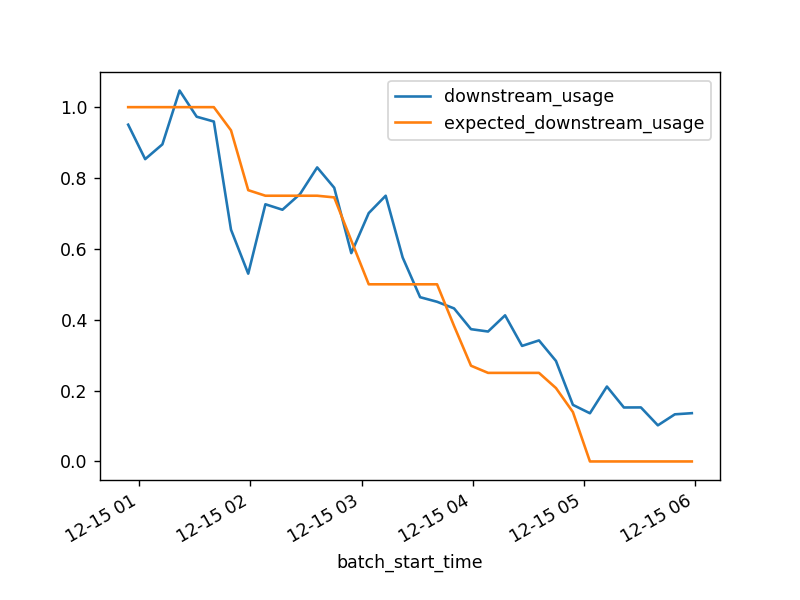

In [12]:
data.plot(x='batch_start_time', y=['downstream_usage', 'expected_downstream_usage'], kind='line')

In [13]:
display(data[['error', 'relative_error']].describe(include='all'))

,error,relative_error
count,34.000000,34.000000
mean,0.102205,0.187562
std,0.072062,0.159672
min,0.004991,0.006655
25%,0.042145,0.060705
50%,0.085761,0.136137
75%,0.144088,0.303399
max,0.280360,0.649770


<IPython.core.display.Javascript object>


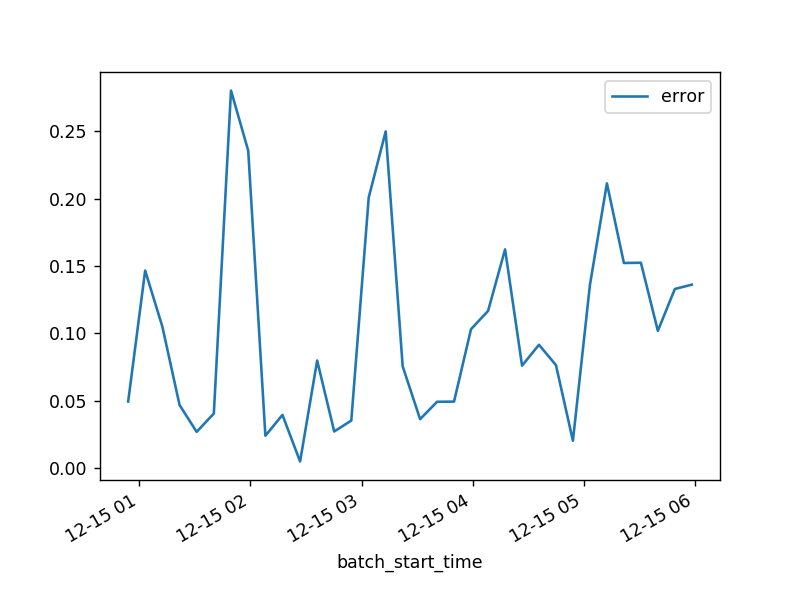

In [14]:
data.plot(x='batch_start_time', y='error', kind='line')

<IPython.core.display.Javascript object>


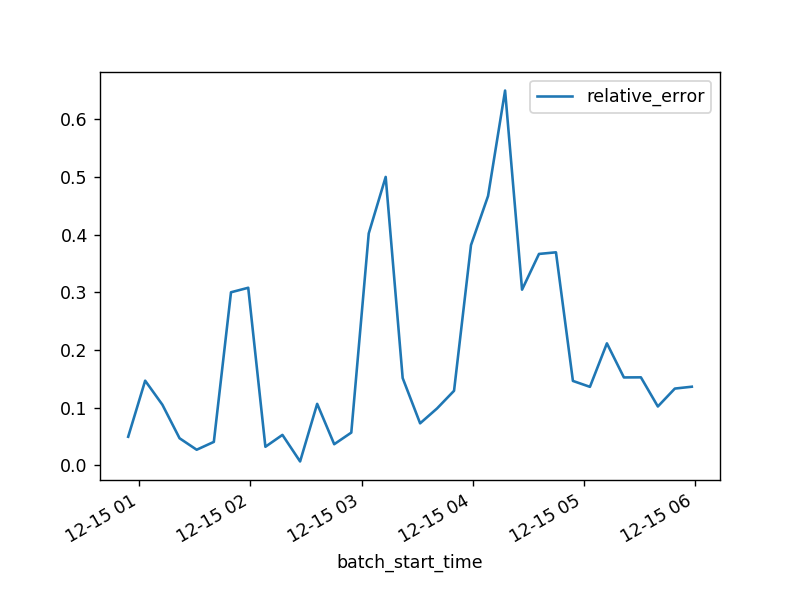

In [15]:
data.plot(x='batch_start_time', y='relative_error', kind='line')